# 五、 GAT-节点分类
- 图注意力网络（Graph Attention Network, GAT）
- 它一种基于注意力机制的图神经网络模型。核心思想是通过​​自注意力机制​​，让图中的每个节点在聚合邻居信息时，能够​​自适应地学习不同邻居的重要性权重​​，而不是平等对待所有邻居。
- 支持多头注意力，增强模型表达能力。
- 无需预先知道图结构，适用于归纳式（inductive）任务，如动态图。

Number of nodes: 2708
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
GAT(
  (gat1): GATConv(1433, 8, heads=8)
  (gat2): GATConv(64, 7, heads=1)
)
Epoch: 010, Loss: 1.9082, Train: 0.7500, Val: 0.4080, Test: 0.4220
Epoch: 020, Loss: 1.8699, Train: 0.9500, Val: 0.7740, Test: 0.7650
Epoch: 030, Loss: 1.8088, Train: 0.9786, Val: 0.7980, Test: 0.7940
Epoch: 040, Loss: 1.7294, Train: 0.9714, Val: 0.7860, Test: 0.7690
Epoch: 050, Loss: 1.6682, Train: 0.9643, Val: 0.7720, Test: 0.7790
Epoch: 060, Loss: 1.5706, Train: 0.9714, Val: 0.8020, Test: 0.8180
Epoch: 070, Loss: 1.4559, Train: 0.9786, Val: 0.8020, Test: 0.7910
Epoch: 080, Loss: 1.3853, Train: 0.9714, Val: 0.8020, Test: 0.8020
Epoch: 090, Loss: 1.3146, Train: 0.9786, Val: 0.8060, Test: 0.8100
Epoch: 100, Loss: 1.2483, Train: 0.9714, Val: 0.8100, Test: 0.8260


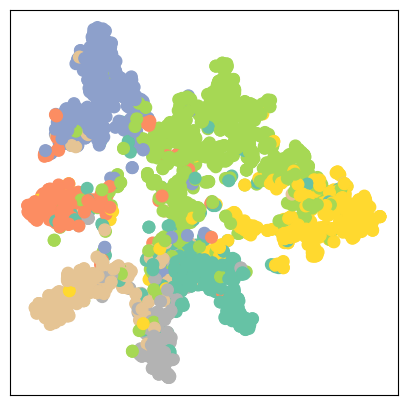

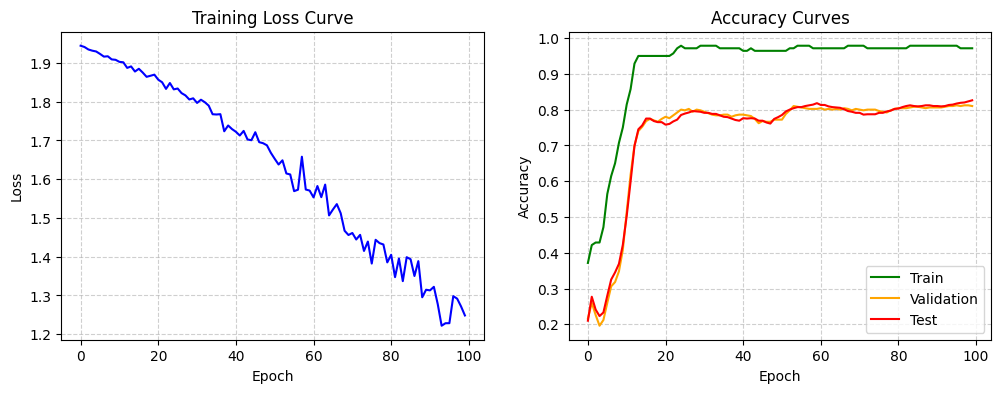

=== Final Results ===
Best Validation Accuracy: 0.8120
Final Train Accuracy: 0.9714
Final Validation Accuracy: 0.8100
Final Test Accuracy: 0.8260


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv  # GAT层
from torch_geometric.datasets import Planetoid  # 加载数据集
from torch_geometric.transforms import NormalizeFeatures  # 归一化
import matplotlib.pyplot as plt  # 可视化
from sklearn.manifold import TSNE  # 降维

# 加载Cora数据集
dataset = Planetoid(root='../datasets', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# 检查掩码是否正确加载
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")


# GAT
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8):
        super(GAT, self).__init__()
        # 第二层使用8个head
        self.gat1 = GATConv(num_features, hidden_channels, heads=heads, dropout=0.7)
        # 第二层使用1个head，concat=False
        self.gat2 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # ELU激活函数，传统的ReLU的改进版，用于激活非线性
        x = self.gat2(x, edge_index)
        return x


# 初始化模型，隐藏层核数是8，注意力头是8
model = GAT(num_features=dataset.num_node_features,
            hidden_channels=8,
            num_classes=dataset.num_classes,
            heads=8)
print(model)

# 设置损失函数与优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)


# 训练函数
def train():
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清空梯度
    out = model(data.x, data.edge_index)  # 前向传播，计算输出
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新参数
    return loss.item()


# 测试函数
def test():
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # 前向传播，计算输出
        results = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = out.argmax(dim=1)  # 选择概率最大的类别作为预测结果
            acc = pred[mask].eq(data.y[mask]).float().mean().item()
            results.append(acc)
    return results


# 训练过程记录
train_losses = []
train_accs = []
val_accs = []
test_accs = []
best_val_acc = 0
best_model_state = None

# 迭代训练
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()

    # 记录指标
    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'output/05-gat-node.pth')
    
    # 打印训练信息
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


# 降维并可视化
def visualize(h, color, epoch=None, save=False):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


# 分类结果可视化
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# 训练曲线可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train', color='green')
plt.plot(val_accs, label='Validation', color='orange')
plt.plot(test_accs, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 最终评估
model.load_state_dict(best_model_state)
final_train, final_val, final_test = test()

print('=== Final Results ===')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Final Train Accuracy: {final_train:.4f}')
print(f'Final Validation Accuracy: {final_val:.4f}')
print(f'Final Test Accuracy: {final_test:.4f}')